# Bidirectional Encoder Representations from Transformers (BERT)

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

# Input Representation
BERT的输入：两个句子，如下图
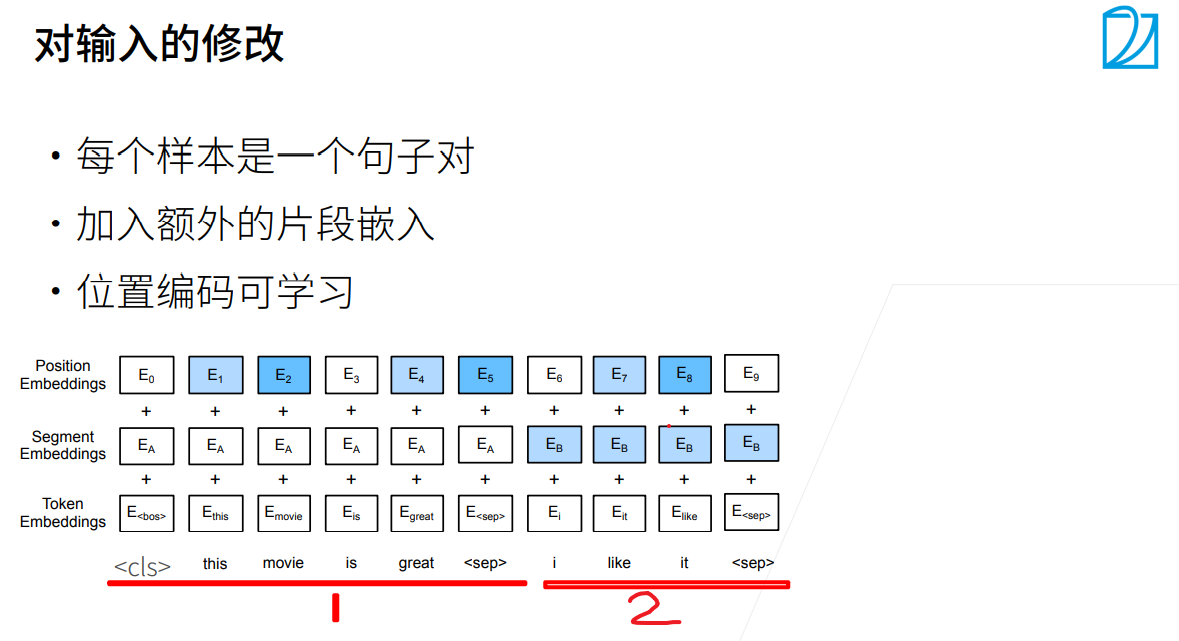

In [2]:
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """Get tokens of the BERT input sequence and their segment IDs."""
    tokens = ['<cls>'] + tokens_a + ['<sep>'] # 第一个句子
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None: # 第二个句子
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

# BERTEncoder class
BERT的Encoder

In [3]:
class BERTEncoder(nn.Module):
    """BERT encoder."""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens) # 第一个token
        self.segment_embedding = nn.Embedding(2, num_hiddens) # 第二个token
        self.blks = nn.Sequential()
        for i in range(num_layers): # num_layers就是多少个transform的block
            # 就是transform的编码器
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len, num_hiddens)) # BERT把位置编码设置成可学习的了

    def forward(self, tokens, segments, valid_lens):
        X = self.token_embedding(tokens) + self.segment_embedding(segments) # 输入就是两个句子加起来
        X = X + self.pos_embedding.data[:, :X.shape[1], :] # 把位置编码加上
        for blk in self.blks: # 然后把数据放入block里面
            X = blk(X, valid_lens)
        return X

# Inference of BERTEncoder
bert编码器的推理

In [5]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input,
                      ffn_num_hiddens, num_heads, num_layers, dropout)

tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape # 输出为[B, seq_len, num_hiddens]可以理解成特征num_hiddens

torch.Size([2, 8, 768])

# Masked Language Modeling
带掩码的语言模型，其实就是说把后面的遮蔽（语言模型：预测下一个出现的词）

In [7]:
class MaskLM(nn.Module):
    """The masked language model task of BERT."""
    def __init__(self, vocab_size, num_hiddens, num_inputs=768, **kwargs):
        super(MaskLM, self).__init__(**kwargs)
        # 单隐藏层的MLP
        self.mlp = nn.Sequential(nn.Linear(num_inputs, num_hiddens),
                                 nn.ReLU(),
                                 nn.LayerNorm(num_hiddens),
                                 nn.Linear(num_hiddens, vocab_size))

    def forward(self, X, pred_positions):
        """
        X:bert的encoder的输出
        pred_positions：告诉哪些地方需要预测（其实就是把一个句子随机挖掉了一些，然后添加了mask，预测这些词）
        """
        
        # 下面就是，把要预测的哪些mask的词的特征给拿出来，然后放入MLP中，则会对每个位置进行预测
        num_pred_positions = pred_positions.shape[1]
        pred_positions = pred_positions.reshape(-1)
        batch_size = X.shape[0]
        batch_idx = torch.arange(0, batch_size)
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)
        masked_X = X[batch_idx, pred_positions]
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)
        return mlm_Y_hat

# The forward inference of MaskLM

In [9]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]]) # 第1个样本预测1，5，2位置的词，第二个样本预测6，1，5位置的词
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape # [B, 要预测的长度, 词表⼤小为10000]

torch.Size([2, 3, 10000])

利⽤遮蔽下的预测词元mlm_Y的真实值mlm_Y_hat，我们可以计算在BERT预训练中的遮蔽语⾔模型任务的
交叉熵损失。

In [12]:
mlm_Y = torch.tensor([[7, 8, 9], [10, 20, 30]])
loss = nn.CrossEntropyLoss(reduction='none')
mlm_l = loss(mlm_Y_hat.reshape((-1, vocab_size)), mlm_Y.reshape(-1))
mlm_l.shape # 6个样本2*3

torch.Size([6])

# 下⼀句预测（Next Sentence Prediction）
尽管遮蔽语⾔建模能够编码双向上下⽂来表⽰单词，但它不能显式地建模⽂本对之间的逻辑关系。为了帮助
理解两个⽂本序列之间的关系，BERT在预训练中考虑了⼀个⼆元分类任务——下⼀句预测。在为预训练⽣成
句⼦对时，有⼀半的时间它们确实是标签为“真”的连续句⼦；在另⼀半的时间⾥，第⼆个句⼦是从语料库
中随机抽取的，标记为“假”。
下⾯的NextSentencePred类使⽤单隐藏层的多层感知机来预测第⼆个句⼦是否是BERT输⼊序列中第⼀
个句⼦的下⼀个句⼦。由于Transformer编码器中的⾃注意，特殊词元“<cls>”的BERT表⽰对输⼊的两个句
⼦进⾏编码。因此，多层感知机分类器的输出层（self.output）以X作为输⼊，其中X是多层感知机隐藏
层的输出，其输⼊是编码的“<cls>”词元。

In [14]:
class NextSentencePred(nn.Module):
    """BERT的下⼀句预测任务"""
    def __init__(self, num_inputs, **kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output = nn.Linear(num_inputs, 2)
    def forward(self, X):
        # `X`的形状： (batch size, `num_hiddens`)
        return self.output(X)

# 我们可以看到，NextSentencePred实例的前向推理返回每个BERT输⼊序列的⼆分类预测。

In [15]:
# 默认情况下，PyTorch不会像mxnet中那样展平张量
# 如果flatten=True，则除第⼀个输⼊数据轴外，所有输⼊数据轴都折叠在⼀起
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输⼊形状: (batch size, `num_hiddens`)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

还可以计算两个⼆元分类的交叉熵损失。

In [16]:
nsp_y = torch.tensor([0, 1])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

torch.Size([2])

值得注意的是，上述两个预训练任务中的所有标签都可以从预训练语料库中获得，而⽆需⼈⼯标注。原始
的BERT已经在图书语料库和英⽂维基百科的连接上进⾏了预训练。这两个⽂本语料库⾮常
庞⼤：它们分别有8亿个单词和25亿个单词

# 把所有的东西放在⼀起

在预训练BERT时，最终的损失函数是遮蔽语⾔模型损失函数和下⼀句预测损失函数的线性组合。现在我们
可以通过实例化三个类BERTEncoder、MaskLM和NextSentencePred来定义BERTModel类。前向推理返
回编码后的BERT表⽰encoded_X、遮蔽语⾔模型预测mlm_Y_hat和下⼀句预测nsp_Y_hat

In [19]:
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
        ffn_num_hiddens, num_heads, num_layers, dropout,
        max_len=1000, key_size=768, query_size=768, value_size=768,
        hid_in_features=768, mlm_in_features=768,
        nsp_in_features=768):
        
        super(BERTModel, self).__init__()
        
        # bert的encoder
        self.encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens, num_heads, num_layers,
        dropout, max_len=max_len, key_size=key_size,
        query_size=query_size, value_size=value_size)
        
        self.hidden = nn.Sequential(nn.Linear(hid_in_features, num_hiddens), nn.Tanh())
        
        self.mlm = MaskLM(vocab_size, num_hiddens, mlm_in_features) # 做mask的语言模型
        
        self.nsp = NextSentencePred(nsp_in_features) # 预测句子对是不是相邻的模型
    
    def forward(self, tokens, segments, valid_lens=None, pred_positions=None):
        encoded_X = self.encoder(tokens, segments, valid_lens) # 放入encoder中，对每个词拿到特征
        
        if pred_positions is not None: # 如果预测位置，则放入语言模型中
            mlm_Y_hat = self.mlm(encoded_X, pred_positions)
        else: # 不然就
            mlm_Y_hat = None
        
        # ⽤于下⼀句预测的多层感知机分类器的隐藏层。0是“<cls>”标记的索引。
        nsp_Y_hat = self.nsp(self.hidden(encoded_X[:, 0, :])) # [B, seq_len, num_hiddens]
        return encoded_X, mlm_Y_hat, nsp_Y_hat

### 以上就是BRET模型的定义，当然，还不能训练，因为没有数据，下一节，我们构造送入Bert模型的数据集

# 总结：
